=== Cross-Validation Evaluation ===

=== Training Models ===
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

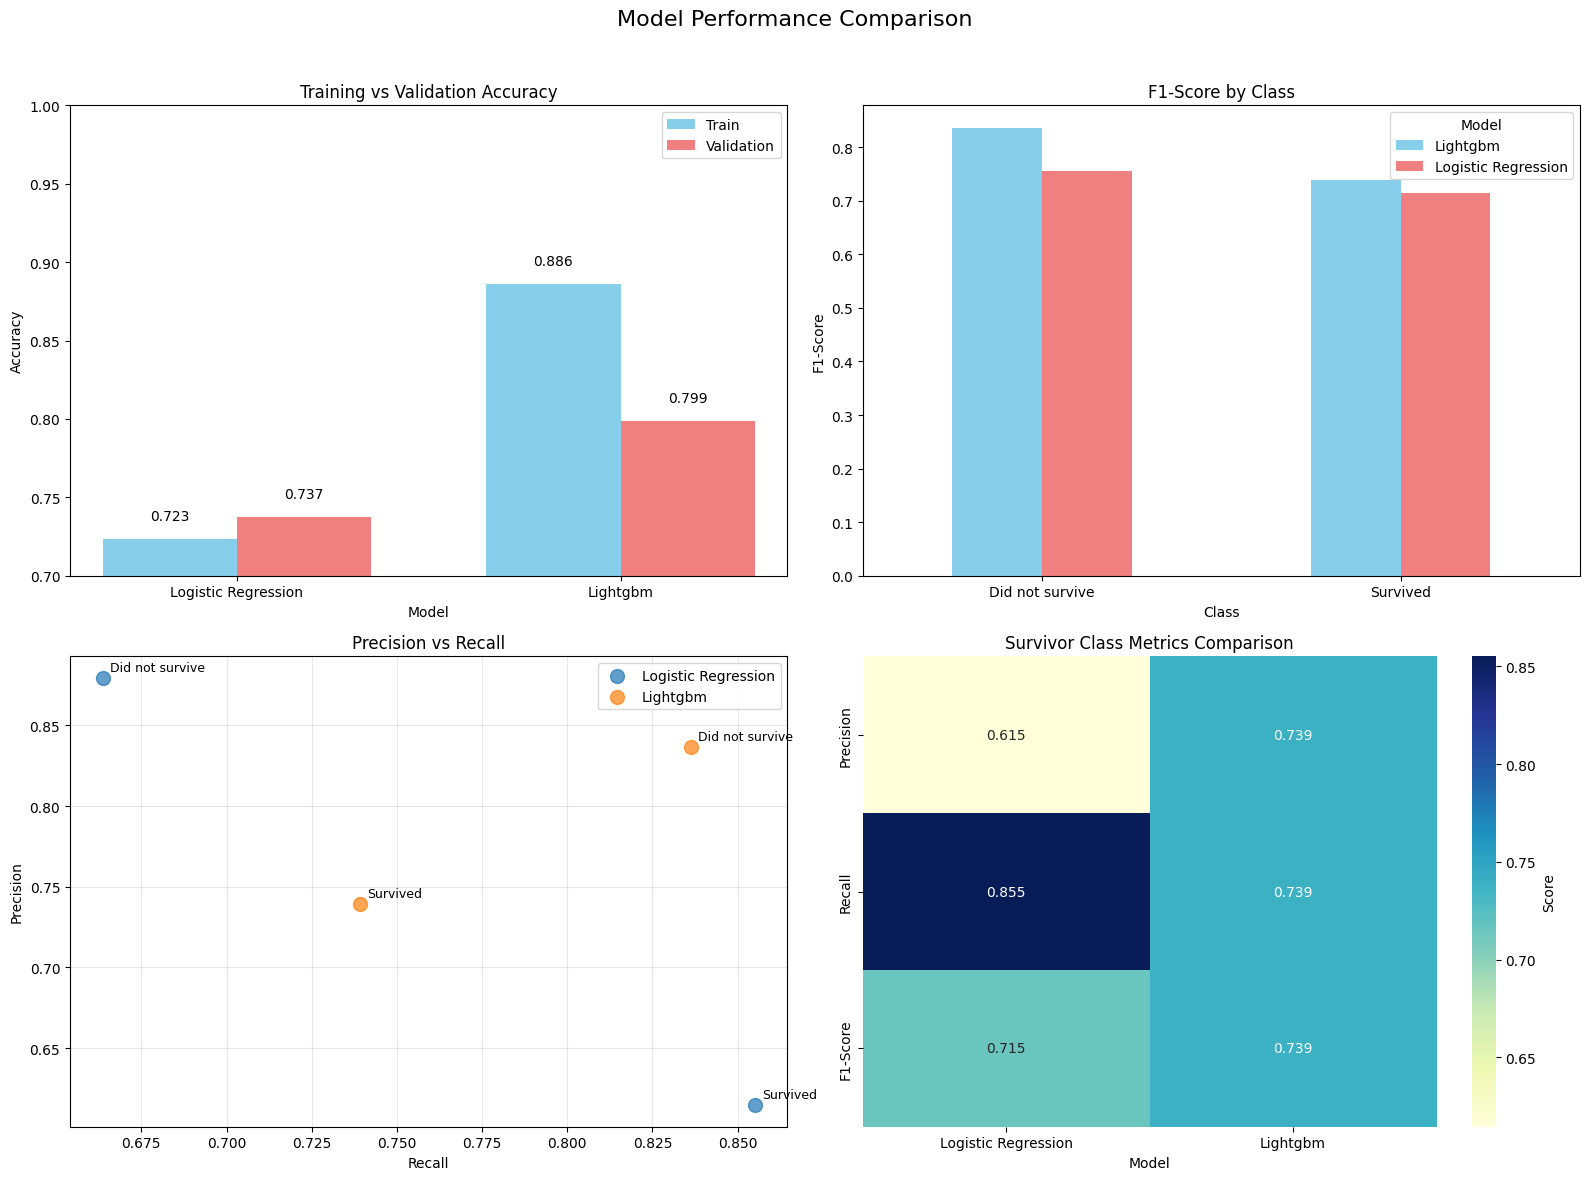

                 Model            Class  Precision    Recall  F1-Score
0  Logistic Regression  Did not survive   0.879518  0.663636  0.756477
1  Logistic Regression         Survived   0.614583  0.855072  0.715152
2  Logistic Regression          Overall   0.737430  0.737430  0.737430
3             Lightgbm  Did not survive   0.836364  0.836364  0.836364
4             Lightgbm         Survived   0.739130  0.739130  0.739130
5             Lightgbm          Overall   0.798883  0.798883  0.798883

=== Feature Importance Analysis ===
                  feature  lgb_importance  lr_coefficient  lr_abs_coefficient  \
0             PassengerId           124.0             NaN                 NaN   
1                     age           148.0             NaN                 NaN   
2               age_class            10.0             NaN                 NaN   
3               age_group             0.0             NaN                 NaN   
4  cat__age_class_Adult_1             NaN        0.005060    

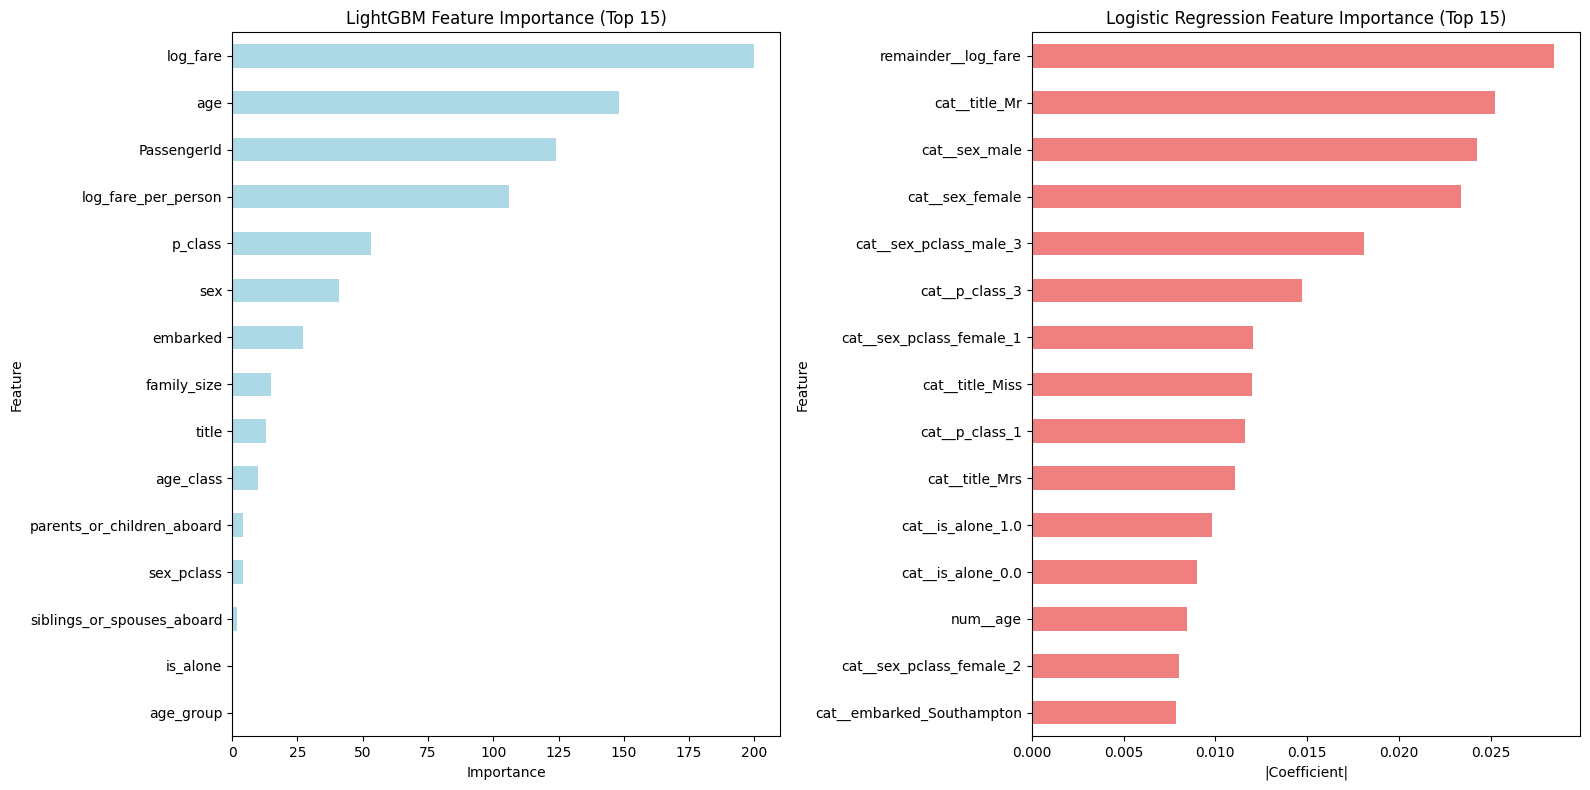

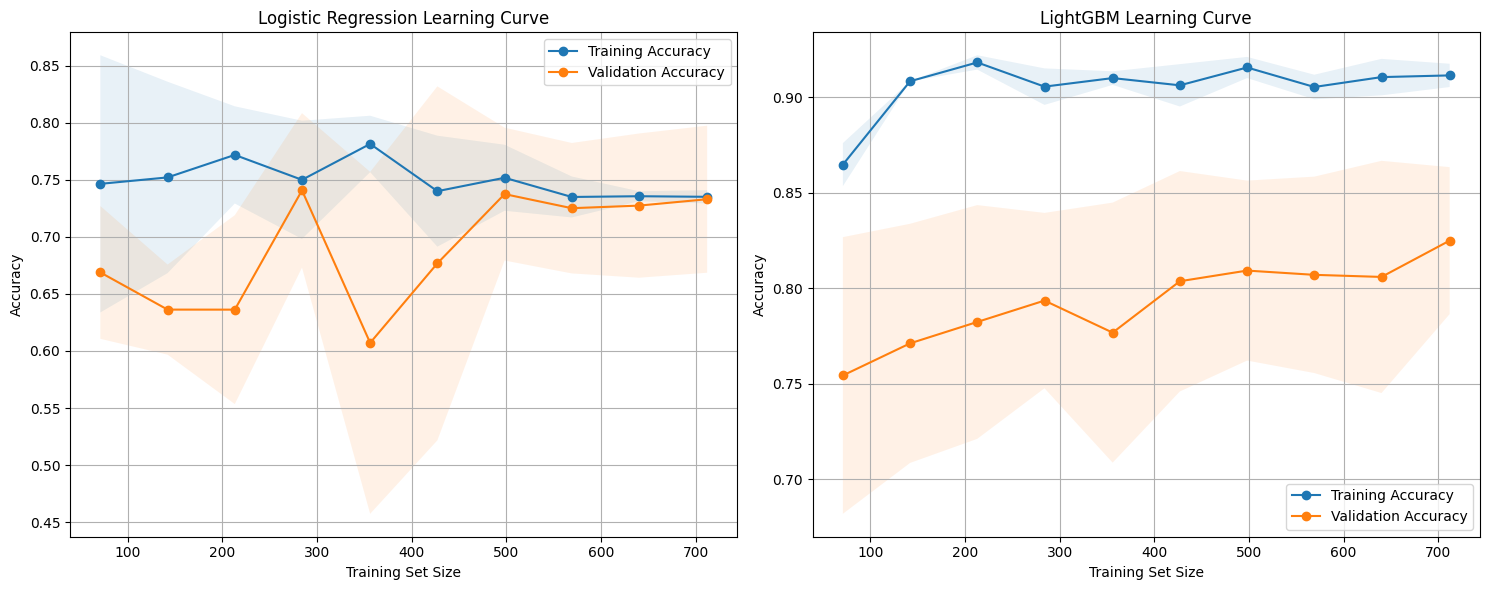


=== Making Predictions ===

=== Generating Submissions ===

=== Saving Pipeline ===

All tasks completed successfully!
Generated 418 predictions
Files created:
- submission_lr.csv
- submission_lgb.csv
- submission_ensemble.csv
- improved_titanic_pipeline.pkl


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
import logging
from datetime import datetime
from sklearn.exceptions import NotFittedError
import sklearn

warnings.filterwarnings('ignore')


class TitanicModelPipeline:
    """
    A comprehensive and robust pipeline for Titanic survival prediction using tuned Logistic Regression
    and LightGBM models. This class implements all preprocessing steps, feature engineering,
    and model evaluation, with a focus on reproducibility and robust handling of test data.

    Key Features:
    - Stateful preprocessing to ensure consistent transformations between train and test data.
    - Robust handling of missing data in both training and test sets.
    - Comprehensive evaluation metrics and visualizations to compare model performance.
    - Error handling to prevent common issues like predicting with an unfitted model.
    - Cross-validation for more reliable performance estimates.
    - Ensemble predictions combining both models.
    - Comprehensive logging and data validation.
    - Model interpretability features.
    """

    def __init__(self, log_level=logging.INFO):
        # Setup logging
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

        # Mappings and constants for feature engineering
        self.title_mapping = {
            'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
            'Dr': 'Officer', 'Rev': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
            'Capt': 'Officer', 'Don': 'Noble', 'Sir': 'Noble', 'Countess': 'Noble',
            'Lady': 'Noble', 'Jonkheer': 'Noble', 'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'
        }
        self.age_bins = [0, 10, 20, 30, 40, 60, 100]
        self.age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle-Aged', 'Elderly']

        # Column definitions for preprocessing
        self.lr_categorical_cols = ['sex', 'embarked', 'p_class', 'title', 'age_group',
                                    'age_class', 'sex_pclass', 'is_alone']
        self.lr_numerical_cols = ['age']
        self.lr_passthrough_cols = ['log_fare', 'siblings_or_spouses_aboard', 'family_size']
        self.lgb_categorical_cols = ['p_class', 'sex', 'embarked', 'title', 'age_group',
                                     'is_alone', 'age_class', 'sex_pclass']
        self.lr_drop_cols = ['log_fare_per_person', 'parents_or_children_aboard']

        # Tuned hyperparameters for the models
        self.lr_best_params = {
            'C': 1, 'class_weight': 'balanced', 'max_iter': 100,
            'penalty': 'l2', 'solver': 'saga'
        }
        self.lgb_best_params = {
            'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 15,
            'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 5,
            'learning_rate': 0.05, 'colsample_bytree': 1.0
        }

        # Initialize models, preprocessors, and state trackers
        self.lr_preprocessor = None
        self.lr_model = None
        self.lgb_model = None
        self.title_age_means = {}
        self.fare_median = None
        self.models_trained = False
        self.feature_importance_summary = None

    def _validate_input_data(self, df, is_test=False):
        """Validate input data format and required columns."""
        self.logger.info("Validating input data...")

        required_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name']
        if not is_test:
            required_cols.append('Survived')

        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Check data types and ranges
        if not is_test and 'Survived' in df.columns:
            if not df['Survived'].isin([0, 1]).all():
                raise ValueError("Survived column must contain only 0s and 1s")

        if 'Pclass' in df.columns and not df['Pclass'].isin([1, 2, 3]).all():
            raise ValueError("Pclass must be 1, 2, or 3")

        if 'Age' in df.columns:
            age_range = df['Age'].dropna()
            if len(age_range) > 0 and (age_range.min() < 0 or age_range.max() > 150):
                self.logger.warning("Age values outside expected range [0, 150] detected")

        self.logger.info(f"Data validation passed. Shape: {df.shape}")

    def _extract_title(self, df):
        """Extract and standardize titles from names with robust fallback logic."""
        df = df.copy()

        # Primary extraction: look for pattern after comma
        df['Title'] = df['Name'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)

        # Fallback: look for pattern with space before title
        mask = df['Title'].isnull()
        if mask.any():
            df.loc[mask, 'Title'] = df.loc[mask, 'Name'].str.extract(r'\s([A-Za-z]+)\.', expand=False)

        # Map to standardized titles
        df['Title'] = df['Title'].map(self.title_mapping)

        # FIXED: Smart fallback based on Sex and Age for remaining missing titles
        mask = df['Title'].isnull()
        if mask.any():
            self.logger.info(f"Applying fallback title assignment for {mask.sum()} records")

            # Apply fallback title assignment row by row to avoid length mismatch
            for idx in df[mask].index:
                row = df.loc[idx]
                if pd.isna(row['Age']):
                    # If age is missing, use simple sex-based assignment
                    if row['Sex'] == 'male':
                        df.loc[idx, 'Title'] = 'Mr'
                    else:
                        df.loc[idx, 'Title'] = 'Miss'
                else:
                    # Use age and sex for better assignment
                    if row['Sex'] == 'male':
                        if row['Age'] < 18:
                            df.loc[idx, 'Title'] = 'Master'
                        else:
                            df.loc[idx, 'Title'] = 'Mr'
                    else:  # female
                        if row['Age'] < 18:
                            df.loc[idx, 'Title'] = 'Miss'
                        else:
                            df.loc[idx, 'Title'] = 'Mrs'

        return df

    def _clean_data(self, df, is_test=False):
        """Clean and standardize the dataset with comprehensive missing value handling."""
        df = df.copy()
        self.logger.info(f"Cleaning data. Initial shape: {df.shape}")

        # Handle missing values in base columns with better strategies
        df['Embarked'].fillna('S', inplace=True)
        if 'Sex' in df.columns:
            df['Sex'].fillna(df['Sex'].mode()[0] if len(df['Sex'].mode()) > 0 else 'male', inplace=True)
        if 'Pclass' in df.columns:
            df['Pclass'].fillna(df['Pclass'].mode()[0] if len(df['Pclass'].mode()) > 0 else 3, inplace=True)

        # Convert data types
        if not is_test and 'Survived' in df.columns:
            df['Survived'] = df['Survived'].astype('category')
        df['Pclass'] = df['Pclass'].astype('category')
        df['Embarked'] = df['Embarked'].map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}).astype('category')
        df['Sex'] = df['Sex'].astype('category').str.lower()
        df['Age'] = df['Age'].astype('float')
        df['Fare'] = df['Fare'].astype('float')

        # Extract titles with robust method
        df = self._extract_title(df)

        # Drop irrelevant columns
        df.drop(columns=[col for col in ['Ticket', 'Name', 'Cabin'] if col in df.columns], inplace=True)

        # Rename columns
        rename_map = {
            'Survived': 'survived', 'Pclass': 'p_class', 'Sex': 'sex', 'Age': 'age',
            'Fare': 'fare', 'Embarked': 'embarked', 'SibSp': 'siblings_or_spouses_aboard',
            'Parch': 'parents_or_children_aboard', 'Title': 'title'
        }
        df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

        # Handle missing values in family columns
        for col in ['siblings_or_spouses_aboard', 'parents_or_children_aboard']:
            if col in df.columns:
                df[col].fillna(0, inplace=True)

        df.reset_index(drop=True, inplace=True)
        if 'id' not in df.columns:
            df.index.name = 'id'

        self.logger.info(f"Data cleaning completed. Final shape: {df.shape}")
        return df

    def _age_imputation(self, df, fit=False):
        """Impute missing ages with enhanced fallback strategy."""
        df = df.copy()

        if fit:
            self.title_age_means = df.groupby('title')['age'].mean().to_dict()
            self.logger.info(f"Calculated age means for {len(self.title_age_means)} titles")

        # Apply title-based imputation
        missing_before = df['age'].isnull().sum()
        for title, mean_age in self.title_age_means.items():
            if not pd.isna(mean_age):  # Only use non-NaN means
                df.loc[(df['title'] == title) & (df['age'].isnull()), 'age'] = mean_age

        # Enhanced fallback: use overall mean
        if df['age'].isnull().any():
            overall_mean = df['age'].mean()
            df['age'].fillna(overall_mean, inplace=True)
            missing_after = df['age'].isnull().sum()
            self.logger.info(f"Age imputation: {missing_before} missing -> {missing_after} missing")

        return df

    def _engineer_features(self, df):
        """Create engineered features with robust handling."""
        df = df.copy()

        # Ensure no missing ages before creating age groups (CRITICAL FIX)
        if df['age'].isnull().any():
            self.logger.warning("Found missing ages before feature engineering. Applying median imputation.")
            df['age'].fillna(df['age'].median(), inplace=True)

        # Create age groups
        df['age_group'] = pd.cut(df['age'], bins=self.age_bins, labels=self.age_labels, right=False)

        # Family-related features
        df['family_size'] = df['siblings_or_spouses_aboard'] + df['parents_or_children_aboard'] + 1
        df['is_alone'] = (df['family_size'] == 1).astype('category')

        # Log transformation of fare (handle zero fares)
        df['log_fare'] = np.log1p(np.maximum(df['fare'], 0))
        df['log_fare_per_person'] = df['log_fare'] / np.maximum(df['family_size'], 1)

        # Interaction features
        df['age_class'] = df['age_group'].astype(str) + '_' + df['p_class'].astype(str)
        df['sex_pclass'] = df['sex'].astype(str) + '_' + df['p_class'].astype(str)

        self.logger.info("Feature engineering completed")
        return df

    def _prepare_logistic_regression_data(self, df, fit=False):
        """Prepare data specifically for Logistic Regression model."""
        df_lr = df.drop(columns=self.lr_drop_cols)
        X = df_lr.drop(columns=['survived', 'fare'], errors='ignore')
        y = df_lr['survived'] if 'survived' in df_lr.columns else None

        # Ensure passthrough columns are numeric
        for col in self.lr_passthrough_cols:
            if col in X.columns:
                X[col] = pd.to_numeric(X[col], errors='coerce')
                # Fill any NaN values created by coercion
                X[col].fillna(X[col].median(), inplace=True)

        if fit:
            self.lr_preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), self.lr_numerical_cols),
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.lr_categorical_cols)
                ],
                remainder='passthrough'
            )
            self.lr_preprocessor.set_output(transform='pandas')
            X_transformed = self.lr_preprocessor.fit_transform(X)
        else:
            if self.lr_preprocessor is None:
                raise NotFittedError("The Logistic Regression preprocessor has not been fitted yet.")
            X_transformed = self.lr_preprocessor.transform(X)
        return X_transformed, y

    def _prepare_lightgbm_data(self, df):
        """Prepare data specifically for LightGBM model."""
        X = df.drop(columns=['survived', 'fare'], errors='ignore')
        y = df['survived'] if 'survived' in df.columns else None

        # Ensure categorical columns exist and convert them
        for col in self.lgb_categorical_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        return X, y

    def _select_features_by_importance(self, X, y, model_type='lgb', top_k=15):
        """Select top K features based on model importance."""
        self.logger.info(f"Selecting top {top_k} features using {model_type} model")

        if model_type == 'lgb':
            temp_model = LGBMClassifier(**self.lgb_best_params, random_state=42)
            temp_model.fit(X, y)
            importances = temp_model.feature_importances_
        else:
            temp_model = LogisticRegression(**self.lr_best_params)
            temp_model.fit(X, y)
            importances = np.abs(temp_model.coef_[0])

        # Get top K feature indices
        top_indices = np.argsort(importances)[-top_k:]
        selected_features = X.columns[top_indices].tolist()

        self.logger.info(f"Selected features: {selected_features}")
        return X.iloc[:, top_indices], selected_features

    def evaluate_with_cv(self, train_df, cv_folds=5, random_state=42):
        """Evaluate models using cross-validation for more robust performance estimates."""
        self.logger.info(f"Starting {cv_folds}-fold cross-validation")

        # Validate and preprocess data
        self._validate_input_data(train_df)
        train_df = self._clean_data(train_df)
        train_df['fare'].fillna(train_df['fare'].median(), inplace=True)
        train_df = self._age_imputation(train_df, fit=True)
        train_df = self._engineer_features(train_df)

        # Prepare data for both models
        X_lr, y = self._prepare_logistic_regression_data(train_df, fit=True)
        X_lgb, _ = self._prepare_lightgbm_data(train_df)

        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

        # Cross-validation for Logistic Regression
        lr_model = LogisticRegression(**self.lr_best_params)
        lr_cv_scores = cross_val_score(lr_model, X_lr, y, cv=cv, scoring='accuracy', n_jobs=-1)

        # Cross-validation for LightGBM
        lgb_model = LGBMClassifier(random_state=random_state, n_jobs=-1, **self.lgb_best_params)
        lgb_cv_scores = cross_val_score(lgb_model, X_lgb, y, cv=cv, scoring='accuracy', n_jobs=-1)

        cv_results = {
            'lr_cv_mean': lr_cv_scores.mean(),
            'lr_cv_std': lr_cv_scores.std(),
            'lr_cv_scores': lr_cv_scores,
            'lgb_cv_mean': lgb_cv_scores.mean(),
            'lgb_cv_std': lgb_cv_scores.std(),
            'lgb_cv_scores': lgb_cv_scores
        }

        self.logger.info(f"CV Results - LR: {cv_results['lr_cv_mean']:.4f} ± {cv_results['lr_cv_std']:.4f}")
        self.logger.info(f"CV Results - LGB: {cv_results['lgb_cv_mean']:.4f} ± {cv_results['lgb_cv_std']:.4f}")

        return cv_results

    def train(self, train_df, val_split=0.2, random_state=42, use_feature_selection=False):
        """Train both models with comprehensive preprocessing and evaluation."""
        self.logger.info("Starting model training pipeline")

        # Validate and preprocess data
        self._validate_input_data(train_df)
        train_df = self._clean_data(train_df)
        self.fare_median = train_df['fare'].median()
        train_df['fare'].fillna(self.fare_median, inplace=True)
        train_df = self._age_imputation(train_df, fit=True)
        train_df = self._engineer_features(train_df)

        results = {}

        # Train Logistic Regression
        self.logger.info("Training Logistic Regression model...")
        X_lr, y_lr = self._prepare_logistic_regression_data(train_df, fit=True)

        # Optional feature selection
        if use_feature_selection:
            X_lr, selected_features = self._select_features_by_importance(X_lr, y_lr, 'lr')

        X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
            X_lr, y_lr, test_size=val_split, random_state=random_state, stratify=y_lr
        )

        self.lr_model = LogisticRegression(**self.lr_best_params)
        self.lr_model.fit(X_train_lr, y_train_lr)

        lr_train_acc = self.lr_model.score(X_train_lr, y_train_lr)
        lr_val_pred = self.lr_model.predict(X_val_lr)
        lr_val_acc = accuracy_score(y_val_lr, lr_val_pred)

        results['logistic_regression'] = {
            'train_accuracy': lr_train_acc, 'val_accuracy': lr_val_acc,
            'classification_report': classification_report(y_val_lr, lr_val_pred),
            'predictions': lr_val_pred, 'y_true': y_val_lr
        }
        self.logger.info(f"LR - Train: {lr_train_acc:.4f}, Val: {lr_val_acc:.4f}")

        # Train LightGBM
        self.logger.info("Training LightGBM model...")
        X_lgb, y_lgb = self._prepare_lightgbm_data(train_df)

        if use_feature_selection:
            X_lgb, _ = self._select_features_by_importance(X_lgb, y_lgb, 'lgb')

        X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
            X_lgb, y_lgb, test_size=val_split, random_state=random_state, stratify=y_lgb
        )

        self.lgb_model = LGBMClassifier(random_state=random_state, is_unbalance=True, n_jobs=-1, **self.lgb_best_params)
        self.lgb_model.fit(
            X_train_lgb, y_train_lgb,
            categorical_feature=self.lgb_categorical_cols,
            eval_set=[(X_val_lgb, y_val_lgb)], eval_metric='logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False), lgb.log_evaluation(period=0)]
        )

        lgb_train_acc = self.lgb_model.score(X_train_lgb, y_train_lgb)
        lgb_val_pred = self.lgb_model.predict(X_val_lgb)
        lgb_val_acc = accuracy_score(y_val_lgb, lgb_val_pred)

        results['lightgbm'] = {
            'train_accuracy': lgb_train_acc, 'val_accuracy': lgb_val_acc,
            'classification_report': classification_report(y_val_lgb, lgb_val_pred),
            'predictions': lgb_val_pred, 'y_true': y_val_lgb
        }
        self.logger.info(f"LGB - Train: {lgb_train_acc:.4f}, Val: {lgb_val_acc:.4f}")

        self.models_trained = True
        self.logger.info("Model training completed successfully")
        return results

    def predict(self, test_df, model='both'):
        """Make predictions on test data with comprehensive preprocessing."""
        if not self.models_trained:
            raise NotFittedError("Models have not been trained yet. Please call the 'train' method first.")

        self.logger.info(f"Making predictions using {model} model(s)")
        self._validate_input_data(test_df, is_test=True)

        test_df = self._clean_data(test_df, is_test=True)
        test_df['fare'].fillna(self.fare_median, inplace=True)
        test_df = self._age_imputation(test_df, fit=False)
        test_df = self._engineer_features(test_df)

        predictions = {}
        if model in ['lr', 'both']:
            X_test_lr, _ = self._prepare_logistic_regression_data(test_df, fit=False)
            predictions['logistic_regression'] = self.lr_model.predict(X_test_lr)
            predictions['logistic_regression_proba'] = self.lr_model.predict_proba(X_test_lr)[:, 1]

        if model in ['lgb', 'both']:
            X_test_lgb, _ = self._prepare_lightgbm_data(test_df)
            predictions['lightgbm'] = self.lgb_model.predict(X_test_lgb)
            predictions['lightgbm_proba'] = self.lgb_model.predict_proba(X_test_lgb)[:, 1]

        self.logger.info("Predictions completed")
        return predictions

    def predict_ensemble(self, test_df, weights=None):
        """Make ensemble predictions combining both models."""
        if weights is None:
            weights = [0.5, 0.5]  # Equal weighting by default

        self.logger.info(f"Making ensemble predictions with weights: LR={weights[0]}, LGB={weights[1]}")
        predictions = self.predict(test_df, model='both')

        # Weighted average of probabilities
        ensemble_proba = (weights[0] * predictions['logistic_regression_proba'] +
                         weights[1] * predictions['lightgbm_proba'])

        ensemble_pred = (ensemble_proba > 0.5).astype(int)

        return {
            'ensemble_predictions': ensemble_pred,
            'ensemble_probabilities': ensemble_proba,
            **predictions
        }

    def get_feature_importance_summary(self):
        """Get a comprehensive feature importance summary."""
        if not self.models_trained:
            raise NotFittedError("Models must be trained first")

        self.logger.info("Generating feature importance summary")

        # LightGBM importance
        lgb_importance = pd.DataFrame({
            'feature': self.lgb_model.feature_name_,
            'lgb_importance': self.lgb_model.feature_importances_
        })

        # Logistic Regression coefficients
        feature_names = self.lr_preprocessor.get_feature_names_out()
        lr_importance = pd.DataFrame({
            'feature': feature_names,
            'lr_coefficient': self.lr_model.coef_[0],
            'lr_abs_coefficient': np.abs(self.lr_model.coef_[0])
        })

        # Combine and rank
        combined = pd.merge(lgb_importance, lr_importance, on='feature', how='outer')
        combined['lgb_rank'] = combined['lgb_importance'].rank(ascending=False)
        combined['lr_rank'] = combined['lr_abs_coefficient'].rank(ascending=False)
        combined['combined_rank'] = (combined['lgb_rank'] + combined['lr_rank']) / 2

        self.feature_importance_summary = combined.sort_values('combined_rank').reset_index(drop=True)
        return self.feature_importance_summary

    def plot_feature_importance(self, top_n=15):
        """Plot feature importance for both models."""
        if not self.models_trained:
            raise NotFittedError("Models must be trained first")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # LightGBM feature importance
        lgb_importance = pd.DataFrame({
            'feature': self.lgb_model.feature_name_,
            'importance': self.lgb_model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)

        lgb_importance.plot(x='feature', y='importance', kind='barh', ax=ax1,
                           color='lightblue', legend=False)
        ax1.set_xlabel('Importance')
        ax1.set_ylabel('Feature')
        ax1.set_title(f'LightGBM Feature Importance (Top {top_n})')
        ax1.invert_yaxis()

        # Logistic Regression coefficients (absolute values)
        feature_names = self.lr_preprocessor.get_feature_names_out()
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': np.abs(self.lr_model.coef_[0])
        }).sort_values('coefficient', ascending=False).head(top_n)

        coef_df.plot(x='feature', y='coefficient', kind='barh', ax=ax2,
                    color='lightcoral', legend=False)
        ax2.set_xlabel('|Coefficient|')
        ax2.set_ylabel('Feature')
        ax2.set_title(f'Logistic Regression Feature Importance (Top {top_n})')
        ax2.invert_yaxis()

        plt.tight_layout()
        plt.show()

    def compare_models(self, results):
        """Create a comprehensive comparison of model performance with enhanced visualizations."""
        comparison_data = []
        for model_name, metrics in results.items():
            report = classification_report(metrics['y_true'], metrics['predictions'], output_dict=True)
            for class_label, class_metrics in report.items():
                if class_label in ['0', '1']:
                    comparison_data.append({
                        'Model': model_name.replace('_', ' ').title(),
                        'Class': 'Did not survive' if class_label == '0' else 'Survived',
                        'Precision': class_metrics['precision'],
                        'Recall': class_metrics['recall'],
                        'F1-Score': class_metrics['f1-score']
                    })
            comparison_data.append({
                'Model': model_name.replace('_', ' ').title(), 'Class': 'Overall',
                'Precision': metrics['val_accuracy'], 'Recall': metrics['val_accuracy'],
                'F1-Score': metrics['val_accuracy']
            })
        comparison_df = pd.DataFrame(comparison_data)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16)

        # Plot 1: Accuracy comparison
        accuracy_data = comparison_df[comparison_df['Class'] == 'Overall']
        models = accuracy_data['Model'].unique()
        train_accs = [results[model.lower().replace(' ', '_')]['train_accuracy'] for model in models]
        val_accs = [results[model.lower().replace(' ', '_')]['val_accuracy'] for model in models]
        x = np.arange(len(models))
        width = 0.35
        ax1 = axes[0, 0]
        bars1 = ax1.bar(x - width/2, train_accs, width, label='Train', color='skyblue')
        bars2 = ax1.bar(x + width/2, val_accs, width, label='Validation', color='lightcoral')
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Training vs Validation Accuracy')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.set_ylim([0.7, 1.0])

        # Add value labels on bars
        for i, (train, val) in enumerate(zip(train_accs, val_accs)):
            ax1.text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom')
            ax1.text(i + width/2, val + 0.01, f'{val:.3f}', ha='center', va='bottom')

        # Plot 2: F1-Score comparison for each class
        ax2 = axes[0, 1]
        f1_data = comparison_df[comparison_df['Class'] != 'Overall'].pivot(index='Class', columns='Model', values='F1-Score')
        f1_data.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'])
        ax2.set_xlabel('Class')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('F1-Score by Class')
        ax2.legend(title='Model')
        ax2.tick_params(axis='x', rotation=0)

        # Plot 3: Precision-Recall comparison
        ax3 = axes[1, 0]
        for model in models:
            model_data = comparison_df[(comparison_df['Model'] == model) & (comparison_df['Class'] != 'Overall')]
            ax3.scatter(model_data['Recall'], model_data['Precision'], label=model, s=100, alpha=0.7)
            for _, row in model_data.iterrows():
                ax3.annotate(row['Class'], (row['Recall'], row['Precision']), xytext=(5, 5), textcoords='offset points', fontsize=9)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision vs Recall')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Summary metrics heatmap
        ax4 = axes[1, 1]
        summary_data = comparison_df[comparison_df['Class'] == 'Survived'].set_index('Model')[['Precision', 'Recall', 'F1-Score']]
        sns.heatmap(summary_data.T, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'Score'}, ax=ax4)
        ax4.set_title('Survivor Class Metrics Comparison')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        return comparison_df

    def save_pipeline(self, filepath='titanic_pipeline.pkl'):
        """Save the entire pipeline with metadata."""
        if not self.models_trained:
            raise ValueError("No trained models to save")

        self.logger.info(f"Saving pipeline to {filepath}")

        pipeline_data = {
            'lr_model': self.lr_model,
            'lgb_model': self.lgb_model,
            'lr_preprocessor': self.lr_preprocessor,
            'title_age_means': self.title_age_means,
            'fare_median': self.fare_median,
            'feature_importance_summary': self.feature_importance_summary,
            'metadata': {
                'training_date': datetime.now().isoformat(),
                'sklearn_version': sklearn.__version__,
                'lightgbm_version': lgb.__version__,
                'hyperparameters': {
                    'lr': self.lr_best_params,
                    'lgb': self.lgb_best_params
                },
                'feature_columns': {
                    'lr_categorical': self.lr_categorical_cols,
                    'lr_numerical': self.lr_numerical_cols,
                    'lr_passthrough': self.lr_passthrough_cols,
                    'lgb_categorical': self.lgb_categorical_cols
                }
            }
        }

        joblib.dump(pipeline_data, filepath)
        self.logger.info(f"Pipeline saved successfully to {filepath}")

    def load_pipeline(self, filepath='titanic_pipeline.pkl'):
        """Load the entire pipeline with metadata."""
        self.logger.info(f"Loading pipeline from {filepath}")

        try:
            pipeline_data = joblib.load(filepath)

            self.lr_model = pipeline_data['lr_model']
            self.lgb_model = pipeline_data['lgb_model']
            self.lr_preprocessor = pipeline_data['lr_preprocessor']
            self.title_age_means = pipeline_data['title_age_means']
            self.fare_median = pipeline_data['fare_median']
            self.feature_importance_summary = pipeline_data.get('feature_importance_summary')
            self.models_trained = True

            metadata = pipeline_data.get('metadata', {})
            self.logger.info(f"Pipeline loaded successfully from {filepath}")
            self.logger.info(f"Training date: {metadata.get('training_date', 'Unknown')}")
            self.logger.info(f"Sklearn version: {metadata.get('sklearn_version', 'Unknown')}")
            self.logger.info(f"LightGBM version: {metadata.get('lightgbm_version', 'Unknown')}")

        except FileNotFoundError:
            self.logger.error(f"Pipeline file {filepath} not found")
            raise
        except Exception as e:
            self.logger.error(f"Error loading pipeline: {str(e)}")
            raise

    def generate_submission(self, test_df, passenger_ids, model='ensemble', ensemble_weights=None):
        """Generate a submission file for Kaggle competition with ensemble option."""
        self.logger.info(f"Generating submission using {model} predictions")

        if model == 'ensemble':
            predictions = self.predict_ensemble(test_df, weights=ensemble_weights)
            survived = predictions['ensemble_predictions']
        else:
            predictions = self.predict(test_df, model=model)
            if model == 'lr':
                survived = predictions['logistic_regression']
            elif model == 'lgb':
                survived = predictions['lightgbm']
            else:
                # Default to LightGBM if 'both' is specified
                survived = predictions['lightgbm']

        submission = pd.DataFrame({
            'PassengerId': passenger_ids,
            'Survived': survived.astype(int)
        })

        self.logger.info(f"Submission generated with {len(submission)} predictions")
        return submission

    def plot_learning_curves(self, train_df, train_sizes=np.linspace(0.1, 1.0, 10)):
        """Plot learning curves to analyze bias/variance tradeoff."""
        from sklearn.model_selection import learning_curve

        self.logger.info("Generating learning curves")

        # Preprocess data
        self._validate_input_data(train_df)
        train_df = self._clean_data(train_df)
        train_df['fare'].fillna(train_df['fare'].median(), inplace=True)
        train_df = self._age_imputation(train_df, fit=True)
        train_df = self._engineer_features(train_df)

        # Prepare data
        X_lr, y = self._prepare_logistic_regression_data(train_df, fit=True)
        X_lgb, _ = self._prepare_lightgbm_data(train_df)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Learning curve for Logistic Regression
        train_sizes_lr, train_scores_lr, val_scores_lr = learning_curve(
            LogisticRegression(**self.lr_best_params), X_lr, y,
            train_sizes=train_sizes, cv=5, scoring='accuracy', n_jobs=-1
        )

        ax1.plot(train_sizes_lr, np.mean(train_scores_lr, axis=1), 'o-', label='Training Accuracy')
        ax1.plot(train_sizes_lr, np.mean(val_scores_lr, axis=1), 'o-', label='Validation Accuracy')
        ax1.fill_between(train_sizes_lr, np.mean(train_scores_lr, axis=1) - np.std(train_scores_lr, axis=1),
                        np.mean(train_scores_lr, axis=1) + np.std(train_scores_lr, axis=1), alpha=0.1)
        ax1.fill_between(train_sizes_lr, np.mean(val_scores_lr, axis=1) - np.std(val_scores_lr, axis=1),
                        np.mean(val_scores_lr, axis=1) + np.std(val_scores_lr, axis=1), alpha=0.1)
        ax1.set_xlabel('Training Set Size')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Logistic Regression Learning Curve')
        ax1.legend()
        ax1.grid(True)

        # Learning curve for LightGBM
        train_sizes_lgb, train_scores_lgb, val_scores_lgb = learning_curve(
            LGBMClassifier(**self.lgb_best_params, random_state=42), X_lgb, y,
            train_sizes=train_sizes, cv=5, scoring='accuracy', n_jobs=-1
        )

        ax2.plot(train_sizes_lgb, np.mean(train_scores_lgb, axis=1), 'o-', label='Training Accuracy')
        ax2.plot(train_sizes_lgb, np.mean(val_scores_lgb, axis=1), 'o-', label='Validation Accuracy')
        ax2.fill_between(train_sizes_lgb, np.mean(train_scores_lgb, axis=1) - np.std(train_scores_lgb, axis=1),
                        np.mean(train_scores_lgb, axis=1) + np.std(train_scores_lgb, axis=1), alpha=0.1)
        ax2.fill_between(train_sizes_lgb, np.mean(val_scores_lgb, axis=1) - np.std(val_scores_lgb, axis=1),
                        np.mean(val_scores_lgb, axis=1) + np.std(val_scores_lgb, axis=1), alpha=0.1)
        ax2.set_xlabel('Training Set Size')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('LightGBM Learning Curve')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


# Example usage demonstrating all improvements
if __name__ == '__main__':
    # Initialize the improved pipeline
    pipeline = TitanicModelPipeline(log_level=logging.INFO)

    try:
        # Load data (replace with your actual file paths)
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        passenger_ids = test_df['PassengerId']

        print("=== Cross-Validation Evaluation ===")
        cv_results = pipeline.evaluate_with_cv(train_df, cv_folds=5)

        print("\n=== Training Models ===")
        results = pipeline.train(train_df, use_feature_selection=False)

        print("\n=== Comparing Models ===")
        comparison_summary = pipeline.compare_models(results)
        print(comparison_summary)

        print("\n=== Feature Importance Analysis ===")
        importance_summary = pipeline.get_feature_importance_summary()
        print(importance_summary.head(10))

        # Plot feature importance
        pipeline.plot_feature_importance(top_n=15)

        # Plot learning curves
        pipeline.plot_learning_curves(train_df)

        print("\n=== Making Predictions ===")
        # Individual model predictions
        predictions_lr = pipeline.predict(test_df, model='lr')
        predictions_lgb = pipeline.predict(test_df, model='lgb')

        # Ensemble predictions
        ensemble_predictions = pipeline.predict_ensemble(test_df, weights=[0.4, 0.6])

        print("\n=== Generating Submissions ===")
        # Generate different submission files
        submission_lr = pipeline.generate_submission(test_df, passenger_ids, model='lr')
        submission_lgb = pipeline.generate_submission(test_df, passenger_ids, model='lgb')
        submission_ensemble = pipeline.generate_submission(test_df, passenger_ids, model='ensemble', ensemble_weights=[0.4, 0.6])

        # Save submissions
        submission_lr.to_csv('submission_lr.csv', index=False)
        submission_lgb.to_csv('submission_lgb.csv', index=False)
        submission_ensemble.to_csv('submission_ensemble.csv', index=False)

        print("\n=== Saving Pipeline ===")
        pipeline.save_pipeline('improved_titanic_pipeline.pkl')

        print("\nAll tasks completed successfully!")
        print(f"Generated {len(submission_ensemble)} predictions")
        print("Files created:")
        print("- submission_lr.csv")
        print("- submission_lgb.csv")
        print("- submission_ensemble.csv")
        print("- improved_titanic_pipeline.pkl")

    except FileNotFoundError:
        print("Error: train.csv or test.csv not found. Please make sure the files are in the correct directory.")
    except Exception as e:
        print(f"An error occurred: {e}")
        logging.exception("Full traceback:")